In [2]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null
!pip install evaluate
!pip install transformers
!pip install torchvision
!pip install cv

zsh:1: 2.14.5 not found


In [33]:
import keras
from keras import layers

In [34]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

In [6]:
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [12]:
dataset_dir = r"/Users/akhi/Desktop/Hackathon/CIFAKE dataset"

In [13]:
train_dir = os.path.join(r"/Users/akhi/Desktop/Hackathon/CIFAKE dataset", "train")
test_dir = os.path.join(r"/Users/akhi/Desktop/Hackathon/CIFAKE dataset", "test")

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Use 20% of data for validation
)

In [15]:
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 24000 images belonging to 2 classes.


In [16]:
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [17]:
image_dict = {}
from pathlib import Path
from tqdm import tqdm

file_names = []
labels = []
for file in sorted((Path(r"/Users/akhi/Desktop/Hackathon/CIFAKE dataset").glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

120000 120000
(120000, 2)


In [19]:
df.head(10)

,image,label
0,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
1,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
2,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
3,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
4,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
5,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
6,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
7,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
8,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE
9,/Users/akhi/Desktop/Hackathon/CIFAKE dataset/t...,FAKE


In [20]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [21]:
y = df[['label']]

df = df.drop(['label'], axis=1)

ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)

del y

df['label'] = y_resampled

del y_resampled

gc.collect()

print(df.shape)

(120000, 2)


In [22]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())


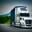

In [23]:
dataset[0]["image"]


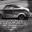

In [24]:
dataset[1]["image"]


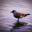

In [25]:
dataset[2]["image"]


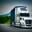

In [26]:
dataset[0]["image"]


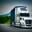

In [27]:
dataset[0]["image"]


In [28]:
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE']


In [29]:
labels_list = ['REAL', 'FAKE'] #list(set(labels))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  
    id2label[i] = label  

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'REAL', 1: 'FAKE'} 

Mapping of Labels to IDs: {'REAL': 0, 'FAKE': 1}


### CNN MODEL

In [44]:
batch_size = 32  # You can change this as needed

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training with batch size
cnn_history = cnn_model.fit(train_data, epochs=5, validation_data=test_data, batch_size=batch_size)

# Evaluate CNN model
y_true = test_data.classes
y_pred = (cnn_model.predict(test_data, batch_size=batch_size) > 0.5).astype("int32")
cnn_report = classification_report(y_true, y_pred)

print("CNN Model Classification Report:")
print(cnn_report)


Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1557s 498ms/step - accuracy: 0.8048 - loss: 0.4596 - val_accuracy: 0.8866 - val_loss: 0.2764
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1531s 490ms/step - accuracy: 0.9048 - loss: 0.2315 - val_accuracy: 0.9107 - val_loss: 0.2191
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1521s 487ms/step - accuracy: 0.9392 - loss: 0.1579 - val_accuracy: 0.9144 - val_loss: 0.2250
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1629s 521ms/step - accuracy: 0.9622 - loss: 0.0979 - val_accuracy: 0.9175 - val_loss: 0.2619
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1680s 537ms/step - accuracy: 0.9794 - loss: 0.0584 - val_accuracy: 0.9147 - val_loss: 0.3306
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.46      0.48     10000
           1       0.50      0.53      0.51     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50  

In [69]:
cnn_model.save('my_cnn_model.keras', include_optimizer=True)